In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from gplearn.genetic import SymbolicRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv


# Мы будем изучать датасет стоимости акций компании Тесла

In [2]:
data = pd.read_csv("/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv", index_col="Date", parse_dates=True)
#data = data.drop(['Volume'],axis=1)
data = data.drop(['Open','Low','Close','Adj Close','Volume'],axis=1)
data.head()

,High
Date,
2010-06-29,5.000
2010-06-30,6.084
2010-07-01,5.184
2010-07-02,4.620
2010-07-06,4.000


# Тест Дики-Фуллера

Тест Дики — Фуллера (DF-тест, Dickey — Fuller test) — это методика, которая используется в прикладной статистике и эконометрике для анализа временных рядов для проверки на стационарность. 

In [3]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data["High"], autolag='AIC')

print(f'ADF Statistic: {adf_test[0]}')
print(f'n_lags: {adf_test[1]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

ADF Statistic: 1.3212555178527396
n_lags: 0.9967253352671337
p-value: 0.9967253352671337
Critial Values:
   1%, -3.4325860929804404
Critial Values:
   5%, -2.8625279573644873
Critial Values:
   10%, -2.5672959172141048


Полученное значение p превышает уровень значимости 0,05, а статистика ADF выше любого из критических значений. Таким образом, временной ряд фактически нестационарен.

In [4]:
#data['Date'] = pd.to_datetime(data['Date'])
#data.set_index('Date',inplace=True)
#data.head()

# **Визуализация временного ряда**

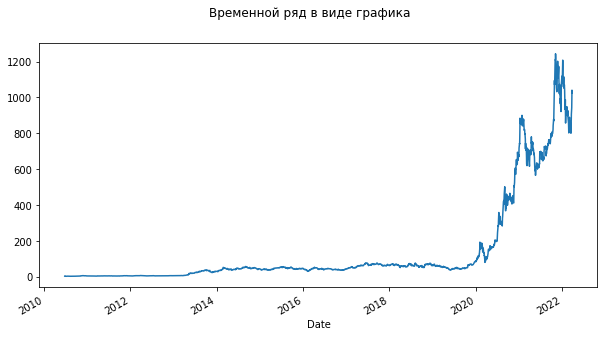

In [5]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
data.plot(ax=ax, legend=False)
pyplot.show()

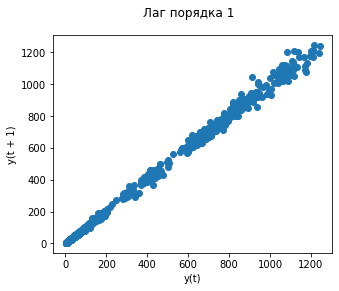

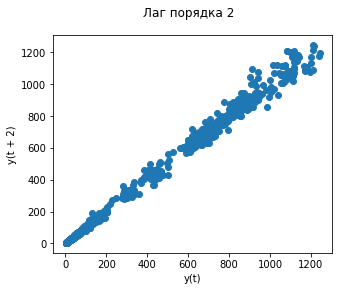

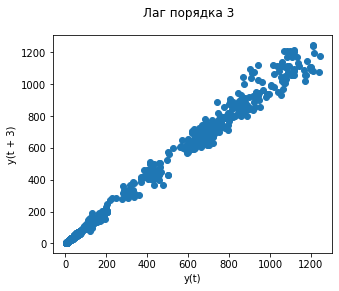

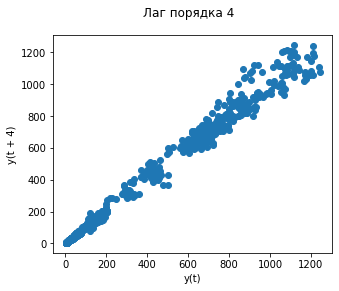

In [6]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(data, lag=i, ax=ax)
    pyplot.show()

**Интерпретация графика:
Если облако точек направлено из левого нижнего угла в правый верхний, то имеет место положительная автокорреляция, автокорреляционные методы прогнозирования хорошо применимы к данному ряду.**

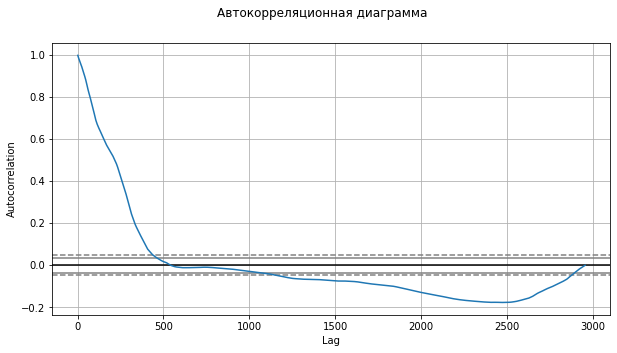

In [7]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(data, ax=ax)
pyplot.show()

# Автокорреляционная функция
Показывает зависимость коэффициента корреляции от лага, то есть корреляцию между исходным временным рядом и временным рядом,сдвинутым на заданный лаг.

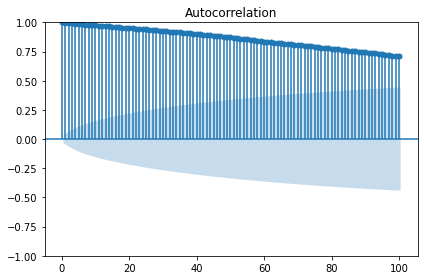

In [8]:
plot_acf(data, lags=100)
plt.tight_layout()

# Частичная автокорреляционная функция
Находит корреляцию остатков, которые остается после удаления эффектов, объясняемых более ранними лагами.

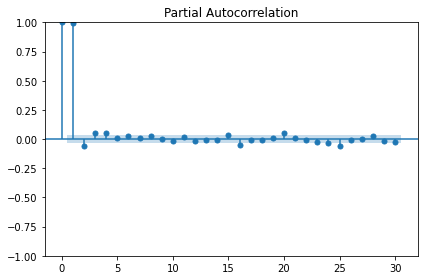

In [9]:
plot_pacf(data, lags=30, method='ywm')
plt.tight_layout()

period. Должен использоваться, если x не является объектом pandas или если индекс x не имеет частоты. Переопределяет периодичность x по умолчанию, если x является объектом pandas с индексом временной серии.

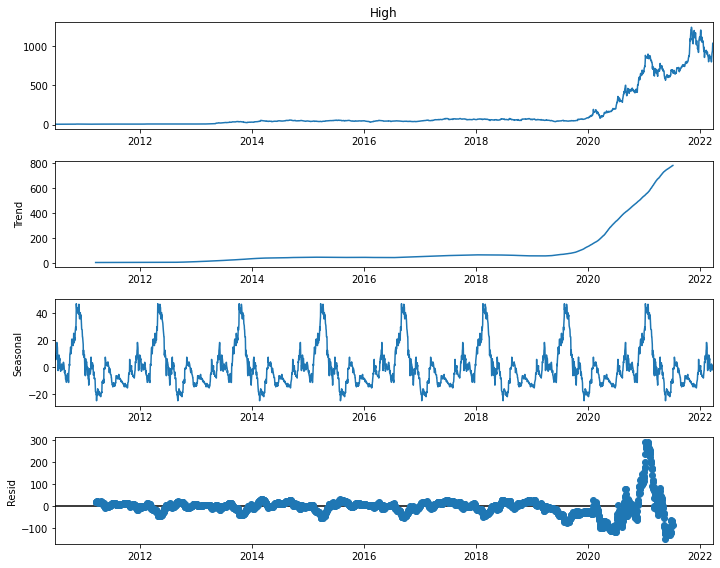

In [10]:
decomposed = seasonal_decompose(data['High'], model = 'add',period=365)
fig = decomposed.plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

# Разделение временного ряда на обучающую и тестовую выборку

In [11]:
data_2 = data.copy()

In [12]:
# Целочисленная метка шкалы времени 
xnum = list(range(data_2.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data_2['High'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

# Прогнозирование временного ряда авторегрессионным методом (ARIMA)

In [13]:
# Вычисление метрики RMSE
# Параметры модели (p,d,q) 
arima_order = (2,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])


# Ошибка прогноза

In [15]:
np.mean(Y), error_arima

(141.77160265290934, 18.209587368126975)

In [16]:
# Записываем предсказания в DataFrame
data_2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
data_2['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)

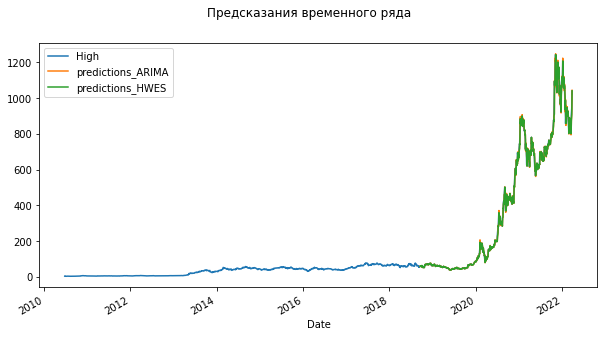

In [17]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data_2.plot(ax=ax, legend=True)
pyplot.show()

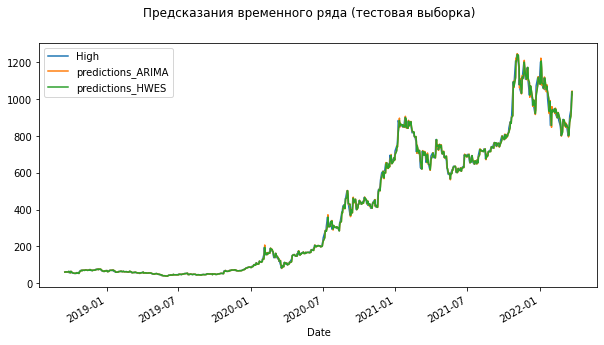

In [18]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

# Прогнозирование временного ряда методом символьной регресии

In [19]:
function_set = ['add', 'sub', 'mul', 'div', 'sin']
SR = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [20]:
SR.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      6.74735e+75      190          1029.23              N/A      4.58m
   1   154.78      8.95535e+16      190          764.612              N/A      1.95m
   2   163.46      3.05292e+23       66          488.857              N/A      1.95m
   3   147.48      6.09806e+17       54          263.613              N/A      1.77m
   4    69.92        3.514e+14       67           74.544              N/A      1.34m
   5    70.09      2.74551e+08       75          74.1956              N/A      1.07m
   6    70.59      3.04953e+09      138           73.129              N/A      1.06m
   7    70.72       5.1904e+08      129          72.9659              N/A      1.11m
   8    84.16      2.07881e+08      114          72.7506              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [21]:
# Предсказания
y_sr = SR.predict(np.array(xnum_test).reshape(-1, 1))
y_sr[:10]

array([70.05860954, 70.60384671, 70.98680994, 71.00385537, 70.58864824,
       70.23505806, 70.26448089, 70.69489383, 71.21206554, 71.31614235])

In [22]:
data_2['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_sr)

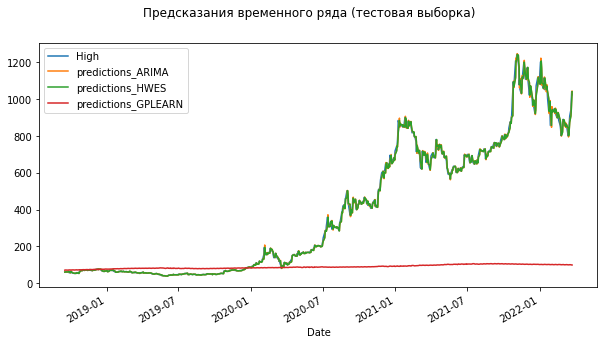

In [23]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

In [24]:
error_SR = mean_squared_error(test, y_sr, squared=False)
# Ошибка прогноза
np.mean(Y), error_SR

(141.77160265290934, 461.62087156997217)

# Качество прогноза моделей

In [25]:

def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [26]:
print("ARIMA")
print_metrics(test, predictions_arima)

print("HWES")
print_metrics(test, predictions_es)

print("\nGPLEARN")
print_metrics(test, y_sr)

ARIMA
R^2: 0.9973817568543869
MSE: 18.209587368126975
MAE: 10.19726791439308
HWES
R^2: 0.997329590549834
MSE: 18.390098069607987
MAE: 10.21503996711533

GPLEARN
R^2: -0.6825990487853044
MSE: 461.62087156997217
MAE: 319.74673394883905


# Вывод: Лучше оказалась ARIMA.  HWES лишь немного уступил.